In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
project_name = 'CAT-dcgan'

In [3]:
DATA_DIR = 'data'

In [4]:
print(os.listdir(DATA_DIR))


['cats']


In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)])
)

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


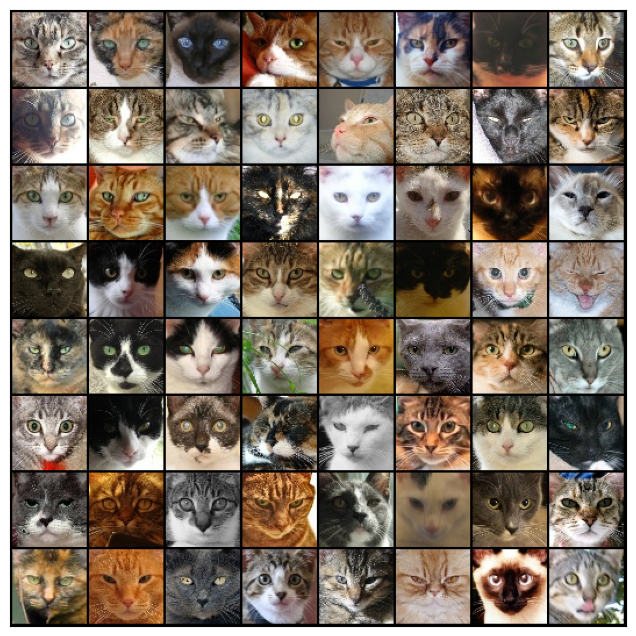

In [10]:
show_batch(train_dl)


In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cpu')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

In [15]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [16]:
discriminator = to_device(discriminator, device)


In [17]:
latent_size = 128


In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


torch.Size([128, 3, 64, 64])


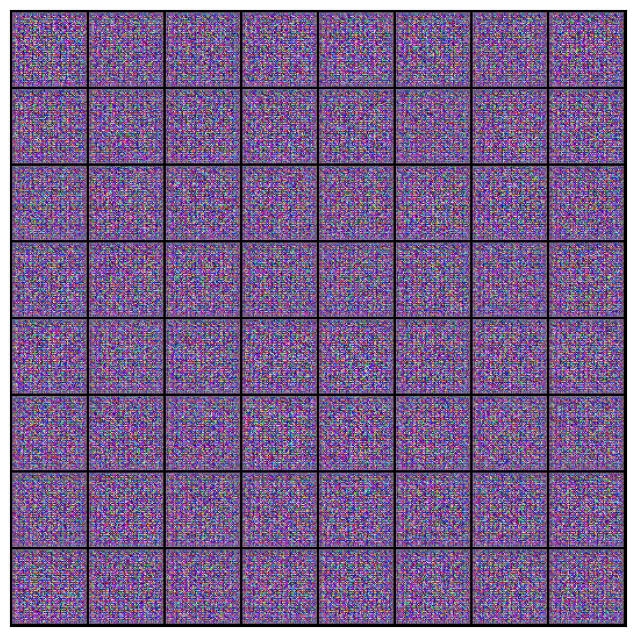

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator, device)


In [21]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [22]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [23]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


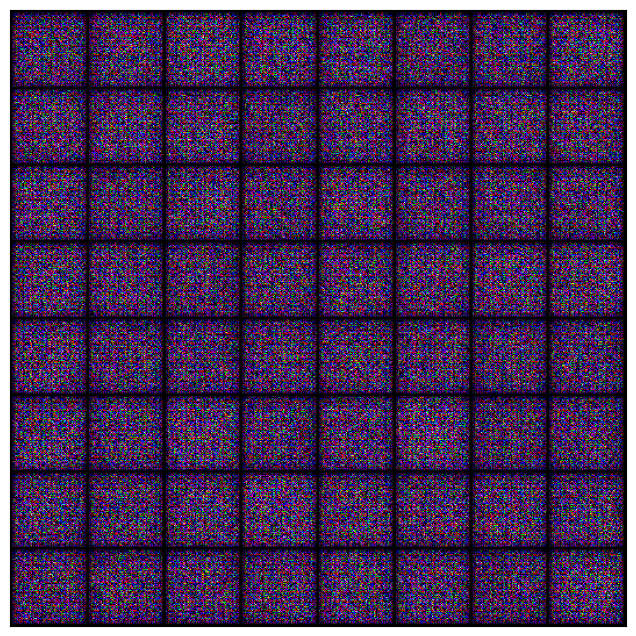

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [27]:
lr = 0.0002
epochs = 60
history = fit(epochs, lr)

  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [1/60], loss_g: 7.1718, loss_d: 0.0098, real_score: 0.9962, fake_score: 0.0060
Saving generated-images-0001.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [2/60], loss_g: 2.8784, loss_d: 0.4938, real_score: 0.7032, fake_score: 0.0747
Saving generated-images-0002.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [3/60], loss_g: 0.7954, loss_d: 1.8925, real_score: 0.2014, fake_score: 0.0023
Saving generated-images-0003.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [4/60], loss_g: 6.1618, loss_d: 0.2981, real_score: 0.9607, fake_score: 0.1997
Saving generated-images-0004.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [5/60], loss_g: 4.9769, loss_d: 0.1636, real_score: 0.9801, fake_score: 0.1237
Saving generated-images-0005.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [6/60], loss_g: 7.6147, loss_d: 0.2135, real_score: 0.8439, fake_score: 0.0052
Saving generated-images-0006.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [7/60], loss_g: 3.5776, loss_d: 0.2487, real_score: 0.8684, fake_score: 0.0862
Saving generated-images-0007.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [8/60], loss_g: 6.4152, loss_d: 0.4933, real_score: 0.9936, fake_score: 0.3440
Saving generated-images-0008.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [9/60], loss_g: 5.6201, loss_d: 0.2566, real_score: 0.9337, fake_score: 0.1581
Saving generated-images-0009.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [10/60], loss_g: 10.0131, loss_d: 1.0362, real_score: 0.9911, fake_score: 0.5754
Saving generated-images-0010.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [11/60], loss_g: 2.6715, loss_d: 0.8462, real_score: 0.5314, fake_score: 0.0335
Saving generated-images-0011.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [12/60], loss_g: 3.4491, loss_d: 0.2901, real_score: 0.8366, fake_score: 0.0790
Saving generated-images-0012.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [13/60], loss_g: 3.4579, loss_d: 0.2546, real_score: 0.8302, fake_score: 0.0490
Saving generated-images-0013.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [14/60], loss_g: 4.5562, loss_d: 0.2632, real_score: 0.8793, fake_score: 0.1072
Saving generated-images-0014.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [15/60], loss_g: 2.9386, loss_d: 0.4921, real_score: 0.7410, fake_score: 0.1356
Saving generated-images-0015.png


  0%|          | 0/247 [00:00<?, ?it/s]

/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saywhat/Documents/CS/GANs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
